In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
ds_train,ds_info = tfds.load('cats_vs_dogs',split= 'train', with_info=True)
ds_train = tfds.load('cats_vs_dogs',split= 'train[:80%]',as_supervised=True)
ds_test =  tfds.load('cats_vs_dogs',split= 'train[80%:]',as_supervised=True)

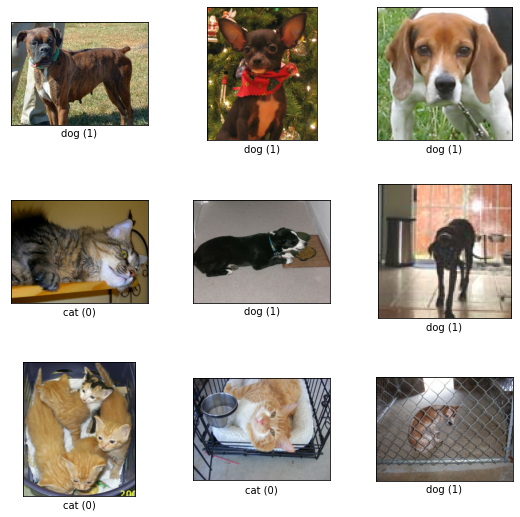

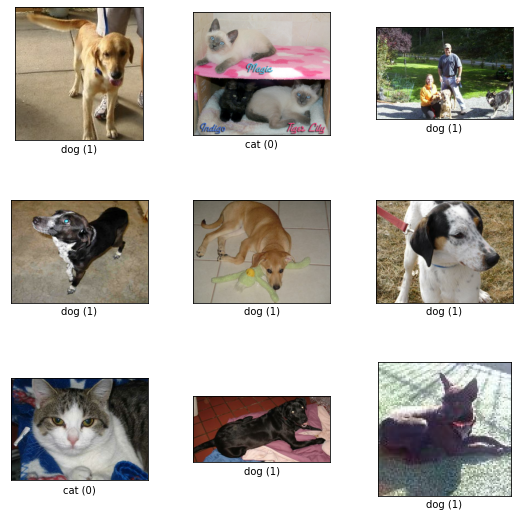

In [4]:
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [5]:
def normalize_and_resize_img(data,y):
    """Normalizes images: `uint8` -> `float32`."""
    # x = data['image']
    # y = data['label']
    # x = tf.cast(x,tf.float32)/255.
    image = tf.image.resize(data, [224, 224])
    return image, y

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,num_parallel_calls=1).batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_train = apply_normalize_on_dataset(ds_train)
ds_test = apply_normalize_on_dataset(ds_test)


In [8]:
ds_train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [56]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
def conv_block_50(num,init_size,x,name,plain = False,First = False):
    for i in range(0,num):
        # print(i)
        if First == True and i == 0:
            short = x
            x = Conv2D(filters= init_size,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_1')(x)
        elif i == 0:
            short = x
            x = Conv2D(filters= init_size,strides=2,padding='same',
                        kernel_size=(1,1),name=f'stage{name}_{i+1}_1')(x)
            # short = Conv2D(filters= init_size,strides=2,padding='same',
            #             kernel_size=(3,3),name=f'stage{name}_{i+1}_1_short')(short)
        else:
            x = Conv2D(filters= init_size,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size*4,
                    kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_3')(x)
        x = BatchNormalization()(x)
        if First == True and i == 0:
            short = Conv2D(filters= init_size*4,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        elif i == 0:
            short = Conv2D(filters= init_size*4,strides=2,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        if plain != True:
            x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        # print(i)
        short = x
    return x

def conv_block_34(num,init_size,x,name,plain = False,First = False):
    for i in range(0,num):
        if First == True and i == 0:
            short = x
            x = Conv2D(filters= init_size,
                        kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_1')(x)
        elif i == 0:
            short = x    
            x = Conv2D(filters= init_size,strides=2,padding='same',
                        kernel_size=(3,3),name=f'stage{name}_{i+1}_1')(x)
        else:
            x = Conv2D(filters= init_size,
                        kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        if First == True and i == 0:
            pass
            # short = Conv2D(filters= init_size,
            #             kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            # short = BatchNormalization()(short)
        elif i == 0:
            short = Conv2D(filters= init_size,strides=2,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        if plain != True:
            x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        short = x
    return x

# a = build_resnet(is_50 = False)
# a.summary()

In [59]:
def build_resnet(input_shape=(32,32,3), is_50 = True,plain =False):
    Input_layer = keras.layers.Input(shape=input_shape)
    x = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = MaxPool2D((3,3),strides=2,padding= 'same')(x)

    if is_50 == True:
        x = conv_block_50(3,64,x,2,plain = plain,First= True)
        # x = Conv2D(128,(1,1),strides=2,padding='same')(x)
        x = conv_block_50(4,128,x,3,plain = plain)
        # x = Conv2D(256,(1,1),strides=2,padding='same')(x)
        x = conv_block_50(6,256,x,4,plain = plain)
        # x = Conv2D(512,(1,1),strides=2,padding='same')(x)
        x = conv_block_50(3,512,x,5,plain = plain)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(2)(x)
    else:
        x = conv_block_34(3,64,x,2,plain = plain,First = True)
        # x = Conv2D(128,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(4,128,x,3,plain = plain)
        # x = Conv2D(256,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(6,256,x,4,plain = plain)
        # x = Conv2D(512,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(3,512,x,5,plain = plain)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(2)(x)        
    model = keras.Model(inputs=Input_layer,outputs=x)
    return model

In [57]:
input_shape = (224,224,3)
Input_layer = keras.layers.Input(shape=input_shape)
testx = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
testx = BatchNormalization()(testx)
testx = Activation(activation='relu')(testx)
testx = MaxPool2D((3,3),strides=2,padding= 'same')(testx)
x = conv_block_34(3,64,testx,2,First= True)
x = conv_block_34(4,128,x,3)
tesmodel = keras.Model(inputs=Input_layer,outputs=x)


In [58]:
tesmodel.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 112, 112, 64) 9472        input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_253 (BatchN (None, 112, 112, 64) 256         conv2d_18[0][0]                  
__________________________________________________________________________________________________
activation_217 (Activation)     (None, 112, 112, 64) 0           batch_normalization_253[0][0]    
____________________________________________________________________________________________

In [36]:
input_shape = (224,224,3)
Input_layer = keras.layers.Input(shape=input_shape)
testx = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
testx = BatchNormalization()(testx)
testx = Activation(activation='relu')(testx)
testx = MaxPool2D((3,3),strides=2,padding= 'same')(testx)
# testx = Conv2D(64,(1,1),strides=2,padding='same')(testx)
test= conv_block_50(3,64,testx,2,plain=False,First= True)
# test = Conv2D(128,(3,3),strides=2,padding='same')(test)
test = conv_block_50(4,128,test,3)
temodel = keras.Model(inputs=Input_layer,outputs=test)

In [37]:
temodel.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 112, 112, 64) 9472        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_161 (BatchN (None, 112, 112, 64) 256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 112, 112, 64) 0           batch_normalization_161[0][0]    
____________________________________________________________________________________________

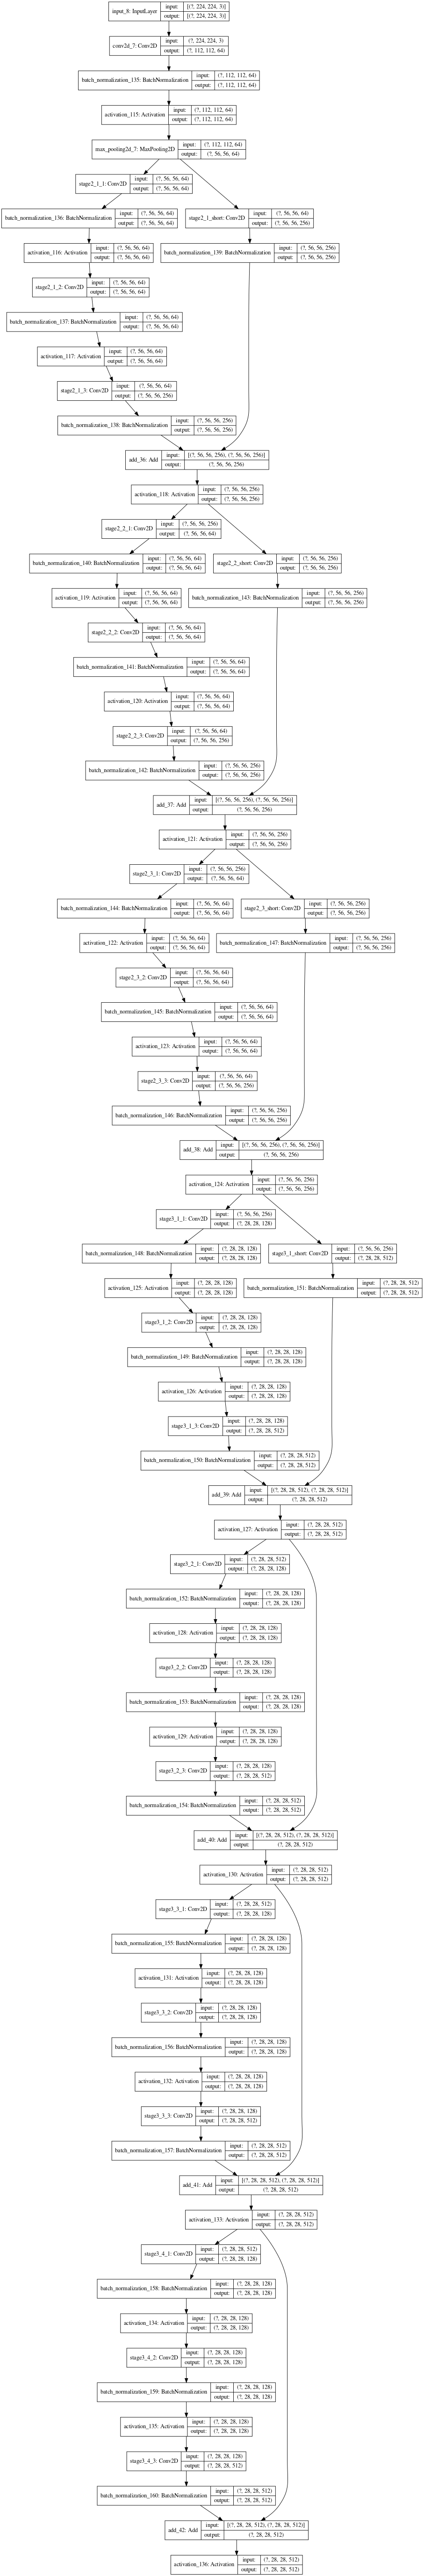

In [34]:
# temodel.summary()
tf.keras.utils.plot_model(temodel, show_shapes=True, dpi=64)

In [60]:
resnet30 = build_resnet(input_shape= (224,224,3),is_50 = False)
resnet30_plain = build_resnet(input_shape= (224,224,3),is_50 = False,plain= True)
# resnet30.summary()
resnet50 = build_resnet(input_shape= (224,224,3))
resnet50_plain = build_resnet(input_shape= (224,224,3),plain= True)
# resnet50.summary()

In [66]:
resnet50.summary()

                 
__________________________________________________________________________________________________
activation_320 (Activation)     (None, 14, 14, 256)  0           batch_normalization_365[0][0]    
__________________________________________________________________________________________________
stage4_1_2 (Conv2D)             (None, 14, 14, 256)  590080      activation_320[0][0]             
__________________________________________________________________________________________________
batch_normalization_366 (BatchN (None, 14, 14, 256)  1024        stage4_1_2[0][0]                 
__________________________________________________________________________________________________
activation_321 (Activation)     (None, 14, 14, 256)  0           batch_normalization_366[0][0]    
__________________________________________________________________________________________________
stage4_1_3 (Conv2D)             (None, 14, 14, 1024) 263168      activation_321[0][0]      

In [17]:
resnet50_plain.summary()

__________________________________________________
stage2_1_1 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_308 (Bat (None, 56, 56, 64)        256       
_________________________________________________________________
activation_280 (Activation)  (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_2 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_309 (Bat (None, 56, 56, 64)        256       
_________________________________________________________________
activation_281 (Activation)  (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_3 (Conv2D)          (None, 56, 56, 256)       16640     
_________________________________________________________________
batch_normalization_310 (

In [63]:
resnet30.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],)
resnet30_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [67]:
BATCH_SIZE = 256
EPOCH = 20
his_res50 = resnet30.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 7.7372 - accuracy: 0.5200

In [ ]:
his_res30_plain = resnet30_plain.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

In [ ]:
his_res50 = resnet50.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

In [ ]:
his_res50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(his_res30.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()